# Hometask №1. Data processing & descriptors search

In [2]:
import pandas as pd
import numpy as np
import re
import string

### Dataset

In [3]:
data = pd.read_csv("C:\\Users\\User\Downloads\\1.csv", sep=',')
data

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier
0,10.1016/j.physb.2010.04.052,4/29/2010,Physica B: Condensed Matter,EXCITONSPECTRAENERGYBANDSTRUCTURECUALS2CRYSTALS,CuGaSe2,0.0,NaN,el_cde_tables,"[['Cu', 1.0], ['Ga', 1.0], ['Se', 2.0]]",1.8235,n
1,10.1016/j.jep.2012.08.025,8/29/2012,Journal of Ethnopharmacology,INVITROINVIVOANTIMICROBIALACTIVITYALGERIANHOGG...,WC,0.0,NaN,el_cde_tables,NaN,2.66,n
2,10.1016/j.physb.2011.08.013,8/18/2011,Physica B: Condensed Matter,OPTICALPROPERTIESGEASTETHINFILMS,Te–Te,0.0,NaN,el_mylogic,NaN,2.99,Refractive index parameters
3,10.1016/j.jnoncrysol.2011.04.001,5/3/2011,Journal of Non-Crystalline Solids,FOURIERTRANSFORMINFRAREDSPECTROSCOPYINVESTIGAT...,SiC,0.0,NaN,el_mylogic,NaN,2.55,RI (± 0.0001)
4,10.1039/C4PY00369A,8/12/2014,Polymer Chemistry,Camptothecin prodrug block copolymer micelles ...,CPT,0.0,NaN,rsc_cde_text,NaN,3,n
...,...,...,...,...,...,...,...,...,...,...,...
4995,10.1016/j.ejpb.2004.05.003,6/26/2004,European Journal of Pharmaceutics and Biopharm...,APPLYINGPATTERNRECOGNITIONMETHODSSTRUCTUREPROP...,Dihydropyridine,0.0,NaN,el_mylogic,NaN,1.679,Index of refraction
4996,10.1039/C4CS00424H,NaN,NaN,NaN,TiO2,0.0,NaN,snowball,"[['O', 2.0], ['Ti', 1.0]]",2.5,refractive index
4997,10.1016/j.numecd.2015.10.010,11/14/2015,"Nutrition, Metabolism and Cardiovascular Diseases",INCREASINGFRUITVEGETABLEINTAKENOEFFECTRETINALV...,cholesterol,0.0,NaN,el_cde_tables,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,4.28,n
4998,10.1016/j.solmat.2010.03.020,4/1/2010,Solar Energy Materials and Solar Cells,DISCUSSIONELECTRICALCHARACTERISTICSIIN013GA087...,SiO2,0.0,NaN,el_mylogic,NaN,1.467,Refractive index


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4555 non-null   object 
 2   Journal                 4555 non-null   object 
 3   Title                   4555 non-null   object 
 4   Name                    4992 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  597 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         2994 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


### Handling duplicates

In [5]:
# number of duplicated rows
data.duplicated().sum()

22

In [6]:
# keep only one of two duplicates
data = data.drop_duplicates(keep='first')
data.shape

(4978, 11)

### Fixing the 'raw_value' column

In [7]:
def remove_range(string):
    """converts ranges into average value"""
    replace_items = ['–', 'to', ', ', '−', '…', '/', '~']
    for i in replace_items:
        if i in string:
            string = string.replace(i, '∼')
    if string[0]=='∼':
        string = string[1:]
    else:
        splitted_string = string.split('∼')
        try:
            string = str((float(splitted_string[0])+float(splitted_string[1]))/2)
        except:
            string = splitted_string[0]
    return string

def remove_bracket(string):
    """removes brackets from values"""
    string = string.replace('[', '(')
    string = string.replace(']', ')')
    import re
    if '(' in string:
        string = re.sub(r'\(.*?\)\ *', '', string)
        string = string.replace(' ', '')
    return string

def remove_error(string):
    """removes measurement error"""
    replace_items = [' ± ', '+']
    for i in replace_items:
        if i in string:
            string = string.replace(i, '±')
    if ' ± ' in string:
        splitted_string = string.split(' ± ')
    else:
        splitted_string = string.split('±')
    string = splitted_string[0]
    error = splitted_string[1]
    return [string, error]

In [8]:
for idx in data.index:
    v = data.loc[idx, 'raw_value']
    if '(' in v or '[':
        v = remove_bracket(v)
    if '±' in v or '+' in v:
        v = remove_error(v)[0]
        try:
            data.at[idx, 'measurement_error'] = remove_error(v)[1]
        except:
            pass
    if '∼' in v or '~' in v or '–' in v or 'to' in v or ', ' in v or '…' in v or '/' in v or '−' in v:
        v = remove_range(v)
    data.at[idx, 'raw_value'] = v

In [9]:
# print unhandled values
for idx in data.index:
    v = data.loc[idx, 'raw_value']
    try:
        float(v)
    except:
        print(f'Unhandled v = {v} in row {idx}')

Unhandled v = <2 in row 470
Unhandled v = 1.30 2.00 1.97 in row 1454
Unhandled v = 1.401b in row 1569
Unhandled v = 1.50000294,15 in row 2725
Unhandled v = 1.878 1.282 1.258 in row 4252
Unhandled v = 2.92 2.79 2.68 in row 4689


In [10]:
# drop invalid values and reset indexes
data = data.drop(labels=[470, 1454, 2725, 4252, 4689], axis=0)

# fix one value manually
data.at[1569, 'raw_value'] = '1.401'

# reset indexes
data.reset_index(inplace=True)

# convert everythinf into float
data['raw_value'] = data['raw_value'].apply(lambda x: float(x))

# check if the column has a float type finally
data['raw_value'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4973 entries, 0 to 4972
Series name: raw_value
Non-Null Count  Dtype  
--------------  -----  
4973 non-null   float64
dtypes: float64(1)
memory usage: 39.0 KB


### Deleting values in the 'raw_value' column that have high measurement errors

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

<AxesSubplot:title={'center':'refractive index measurement errors'}, xlabel='refractive index', ylabel='measurement_error'>

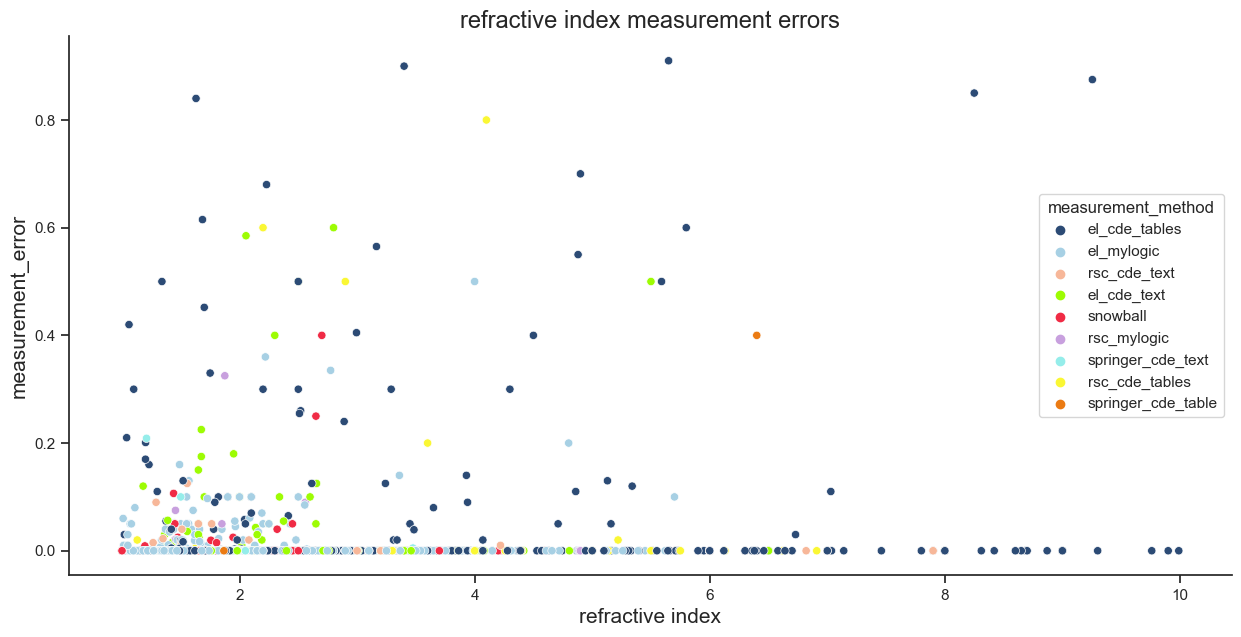

In [14]:
# deleting values that have a measurement error greater than 1
data= data[data.measurement_error < 1]

# scatter plot of refractive index measurement errors
custom_params = {"axes.spines.right": False, "axes.spines.top": False}  #hide top and right spines
sns.set_theme(style="ticks", rc=custom_params)                          #set style
f, ax = plt.subplots(figsize=(15, 7))                                   #get figure size
ax.set_title("refractive index measurement errors", fontsize=17)         #set plot title
plt.xlabel('refractive index', fontsize= 15)                            #set x-axes title
plt.ylabel('measurement_error', fontsize= 15)                           #set y-axes title
palette="RdBu"
marker = 'o'
x=data.loc[:,'raw_value'].values
y=data.loc[:,'measurement_error'].values
sns.scatterplot(x=x, y=y, data=data, marker=marker, hue='measurement_method', palette=['#2C4B75', '#A7D0E4', '#F7B799', '#9dfc03', '#f02b45', '#c8a0de', '#95edea', '#faf734', '#eb7b13'],)

### Handling outliers in the 'raw_value' column

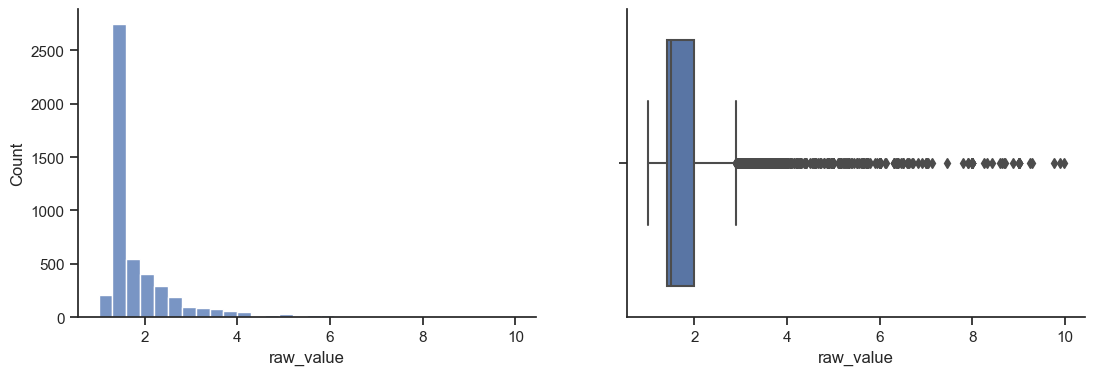

In [15]:
# outliers can be detected with the help of visualization tools
fig, axs = plt.subplots(ncols=2, figsize=(13, 4))
sns.set_style('whitegrid')
sns.histplot(data['raw_value'], kde = False, bins = 30, ax=axs[0])
sns.boxplot(x=data['raw_value'], ax=axs[1])
plt.show()

On the histogram and boxplot wee see that our data is skewed to minimum values and most of the data is located in the range from 1 to 3.

In [16]:
# remove outliers using boxplot
Q1 = data['raw_value'].quantile(0.25)
Q3 = data['raw_value'].quantile(0.75)
IQR = Q3 - Q1

filter = (data['raw_value'] >= Q1 - 1.5 * IQR) & (data['raw_value'] <= Q3 + 1.5 *IQR)
data = data.loc[filter]
data.shape

(4422, 12)

### Fixing the DOI column

To clean the DOI column we applied regular expressions (regex). Extracted DOI is places into 'DOI' column and journal name is places into 'Journal' column.

In [17]:
regex = (r'((10\.\d{4,9}/[A-Z0-9]+[A-Z])|(10\.\d{4,9}/[-._;()/:a-zA-Z0-9]+(-[A-Za-z]{1}))|(10\.\d{4,9}/[-._;()/:a-zA-Z0-9]+[0-9]))')
for idx in data.index:
    doi = data.loc[idx, 'DOI']
    extracted_doi = re.search(regex, doi).group(1)
    journal = doi.replace(extracted_doi, '')
    data.at[idx, 'DOI'] = extracted_doi
    if type(data.at[idx, 'Journal'])!=str and journal!='':
        data.at[idx, 'Journal'] = journal

### Handling missing values in 'Name' and 'normalised_name'

In [ ]:
from rdkit import Chem


In [18]:
# % of missing values for every column
data.isnull().sum() / data.shape[0] * 100

index                      0.000000
DOI                        0.000000
Date                       9.452736
Journal                    4.206242
Title                      9.452736
Name                       0.180914
measurement_error          0.000000
measurement_wavelength    87.426504
measurement_method         0.000000
normalised_name           40.230665
raw_value                  0.000000
specifier                  0.000000
dtype: float64

In [19]:
data_no_name = data[data['Name'].isna()==True]
data_no_name['normalised_name']

9                CCCO
3222        CCOC(C)=O
3250        Cc1ccccc1
3452      CCCCC(CC)CO
3742    Nc1cccc(Cl)c1
4007         O=[Si]=O
4210          CC(C)=O
4213        Nc1ccccc1
Name: normalised_name, dtype: object

We see that all missing names have SMILES in "normalised_name" column. So, we can obtain names by SMILES with the help of CIRpy library.

In [20]:
# fill in gaps in "Name" column
for idx in data.index:
    if type(data.loc[idx, 'Name'])!=str:
        norm_name = data.loc[idx, 'normalised_name']
        new_name = cirpy.resolve(norm_name, 'iupac_name')
        data.at[idx, 'Name'] = new_name
        print(norm_name, new_name)

CCCO Propan-1-ol
CCOC(C)=O Ethyl acetate
Cc1ccccc1 methylbenzene
CCCCC(CC)CO 2-Ethylhexan-1-ol
Nc1cccc(Cl)c1 3-Chloroaniline
O=[Si]=O Dioxosilane
CC(C)=O propan-2-one
Nc1ccccc1 Aniline


Now we can fill in missing values in "normalised_name" column with the help of PubChem API and CIRpy package. Even if "normalised_name" already exists we parse the line through the function, as we want all "normalised_name" values to be in SMILES format. SMILES format is necessary because most of the descriptors are calculated based on SMILES.

In [77]:
for idx in data.index:
    name = data.loc[idx, 'Name']
    try:
        smiles = pcp.get_compounds(name, 'formula')[0].isomeric_smiles
        data.at[idx, 'normalised_name'] = smiles
    except:
        try:
            smiles = pcp.get_compounds(name, 'name')[0].isomeric_smiles
            data.at[idx, 'normalised_name'] = smiles
        except:
            data.at[idx, 'normalised_name'] = np.nan

In [ ]:
for idx in data.index:
    smiles = data.loc[idx, 'normalised_name']
    name = data.loc[idx, 'Name']
    if type(smiles)!=str:
        try:
            new_smiles = cirpy.resolve(name, 'smiles')
        except:
            new_smiles = None
        data.at[idx, 'normalised_name'] = new_smiles

In [21]:
# result dataset (programming was made by supercomputer)
data = pd.read_csv("C:\\Users\\User\Downloads\\data_final.tsv", delimiter='\t')
data['normalised_name'].isnull().sum() / data['normalised_name'].shape[0] * 100

11.924545250392994

There are still missing SMILES. Among them we created a dictionary of names that can be eather corrected or converted to SMILES separately. Other names are deleted because they can not be converted into SMILES unambigously (ex. SnOx).

In [22]:
d_correct = {
            'As40Se60':'As2Se3', 'NMFA':'N-methyl-2-fluoroaniline', 'BiZnBo–':'BiZnBO', 'Si–O':'Si–O',
             'Li2O–GeO2':'Li2O–GeO2', 'GeO2–PbO':'GeO2–PbO', "TiO2's":'TiO2', 'ZnO–Ta2O5–B2O3':'ZnO–Ta2O5–B2O3',
             'CaO–SiO2':'CaO–SiO2', 'GeO2–Bi2O3':'GeO2–Bi2O3', 'Na2O–B2O3':'Na2O–B2O3', 'K2O–TeO2':'K2O–TeO2',
             'CH3–CH2–O–CH2–CH3':'diethyl ether', 'MgO–PbF2–SiO2':'MgO–PbF2–SiO2', 'O–O':'O2', 'F–B':'F–B',
             'PbO–Al2O3':'PbO–Al2O3', 'ZnO–Al2O3':'ZnO–Al2O3', '(−)–Sparteine':'Sparteine', 'PbF2–TeO2–B2O3–Eu2O3':'PbF2–TeO2–B2O3–Eu2O3',
             'CaC2':'Calcium Carbide', 'SiO2 – SnO2':'SiO2–SnO2', 'Ag–ZnO':'Ag–ZnO', 'ZnO –':'ZnO', 'La2O3–B2O3':'La2O3–B2O3',
             'PbO–Sb2O3–B2O3':'PbO–Sb2O3–B2O3', 'BPA–':'BPA', 'Na2O–SiO2':'Na2O–SiO2', 'SiO2(OH)':'HO3Si', 'TeO2–':'TeO2',
             'CH3(CH2)3OH':'butanol', 'TiO2(l)':'TiO2', 'Al(PO3)3':'AlP3O9', 'AgI–B2O3:V2O5':'AgI–B2O3–V2O5',
             'CaF2–Y2O3–ZnO':'CaF2–Y2O3–ZnO', 'Sb2O3–Na2O':'Sb2O3–Na2O', 'Te–Te':'Te–Te', 'TeO2–BaF2':'TeO2–BaF2',
             'SiO2–':'SiO2', 'K2O–B2O3':'K2O–B2O3', 'Ge–Ga–S':'Ge–Ga–S', 'NO3−':'nitrate', 'CuSO4·H2O':'copper sulfate monohydrate',
             'Li2O–Y2O3':'Li2O–Y2O3', 'PbF2–TeO2–B2O3–Sm2O3':'PbF2–TeO2–B2O3–Sm2O3', 'CuSO4·5H2O':'copper sulfate pentahydrate',
             'Na2CO3_aq_23':'Na2CO3', 'GeO2–SiO2':'GeO2–SiO2', 'GeS2–As2S3':'GeS2–As2S3', 'TeO2–B2O3–ZnO':'TeO2–B2O3–ZnO',
             'PbO–Bi2O3':'PbO–Bi2O3', 'ZnSb(wt':'ZnSb', 'K2O–B2O3–Bi2O3':'K2O–B2O3–Bi2O3', 'In2O3–Sc2O3':'In2O3–Sc2O3',
             'ZnO–B2O3':'ZnO–B2O3', 'TiO2–TeO2':'TiO2–TeO2', 'V2O5–GeO2':'V2O5–GeO2', 'Bi2O3–SiO2':'Bi2O3–SiO2',
             'SiO2–Nb2O5':'SiO2–Nb2O5', 'B2O3–SiO2':'B2O3–SiO2', 'SiC(100)':'SiC', 'SiO2–ZrO2':'SiO2–ZrO2',
             'MgO(1 0 0 )':'MgO', 'BaF2–PrF3':'BaF2–PrF3', 'PbO−PbF2−B2O3–Nd2O3':'PbO−PbF2−B2O3–Nd2O3', 'GeS2–Ga2S3–CdS':'GeS2–Ga2S3–CdS',
             'ZnF2–WO3–TeO2':'ZnF2–WO3–TeO2', 'Cd–Se':'Cd–Se', 'SiO2·P2O5':'SiO2–P2O5', 'PbO–TeO2':'PbO–TeO2',
             'TiO2–SiO2':'TiO2–SiO2', 'NO2–BF':'NO2–BF', 'Na2O–P2O5':'Na2O–P2O5'
             }

In [23]:
def complex_smiles(name):
    """makes joint SMILES from a system of molecules (like A-B-C)"""
    smiles_list = []
    names = name.split('–')
    for n in names:
        try:
            smiles = pcp.get_compounds(n, 'formula')[0].isomeric_smiles
        except:
            smiles = pcp.get_compounds(n, 'name')[0].isomeric_smiles
        smiles_list.append(smiles)
    return '.'.join(smiles_list)

In [24]:
for k, v in d_correct.items():
    if '–' in v:
        try:
            d_correct[k] = complex_smiles(v)
        except:
             d_correct[k] = None
    else:
        try:
            smiles = pcp.get_compounds(v, 'formula')[0].isomeric_smiles
            d_correct[k] = smiles
        except:
            try:
                smiles = pcp.get_compounds(v, 'name')[0].isomeric_smiles
                d_correct[k] = smiles
            except:
                d_correct[k] = None

In [25]:
# move SMILES from dictionary to our DataFrame
for idx in data.index:
    name = data.loc[idx, 'Name']
    if name in d_correct.keys():
        data.at[idx, 'normalised_name'] = d_correct[name]

In [26]:
# delete rows with missing "normalised_name"
data = data[data['normalised_name'].isna()==False]

In [27]:
# check if all the SMILES are valid (invalid SMILES can not be handled by RDKit)
for idx in data.index:
    smiles = data.loc[idx, 'normalised_name']
    name = data.loc[idx, 'Name']
    mol = Chem.MolFromSmiles(smiles)
    if mol == None:
        print(f'Invalid smiles: {smiles} in row {idx} for name {name}')

Invalid smiles: C.C.O.CN[OH]C in row 536 for name CH3O(CH2CH2O)nCH3
Invalid smiles: [CH222]O in row 614 for name CH222-OH
Invalid smiles: O(|[Sn](CCCC)(CCCC)CCCC)|[Sn](CCCC)(CCCC)CCCC in row 736 for name BTO
Invalid smiles: B(P)[II] in row 1161 for name Pb[II]
Invalid smiles: O(|[Sn](CCCC)(CCCC)CCCC)|[Sn](CCCC)(CCCC)CCCC in row 1820 for name BTO


In [28]:
# correction of invalid SMILES
data.loc[1161, 'normalised_name'] = '[Pb+2]'
data.loc[736, 'normalised_name'] = 'CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC'
data.loc[1820, 'normalised_name'] = 'CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC'
data.drop(labels=[536, 614], axis=0, inplace=True) # delete two rows because SMILES can not be corrected

### Descriptors search

We use RDKit API, PubChem API, and a python wrapper for PaDEL-Descriptor software to find descriptors.

In [ ]:
from padelpy import from_smiles
from rdkit.Chem import Descriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # supress rdkit warnings
import cirpy
import pubchempy as pcp

In [34]:
def getMolDescriptors(mol, missingVal=None):
    """calculate the full list of RDKit descriptors for a molecule"""
    """missingVal is used when descriptor cannot be calculated"""
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

In [35]:
# create a separate DataFrame with RDKit descriptors
mols = []
for smiles in data['normalised_name'].tolist():
  mol = Chem.MolFromSmiles(smiles)
  mols.append(mol)
allDescrs = [getMolDescriptors(mol) for mol in mols]
rdkit_data = pd.DataFrame(allDescrs)
rdkit_data.head() # so we get 208 RDKit descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.000000,0.000000,0.000000,0.000000,0.494829,291.189,291.189,291.689311,28,4,...,0,0,0,0,0,0,0,0,0,0
1,5.833333,0.833333,5.833333,0.833333,0.480843,195.851,195.851,195.950931,10,1,...,0,0,0,0,0,0,0,0,0,0
2,5.555556,2.222222,5.555556,2.222222,0.256934,40.097,40.097,39.976927,8,0,...,0,0,0,0,0,0,0,0,0,0
3,8.402778,-1.416667,8.402778,1.416667,0.349091,60.084,60.084,59.966756,16,0,...,0,0,0,0,0,0,0,0,0,0
4,10.031944,-0.212963,10.031944,0.025463,0.460748,102.133,92.053,102.068080,42,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# create a separate DatFrame with PubChem descriptors
properties = ['MonoisotopicMass',
              'Complexity',
              'IsotopeAtomCount',
              'AtomStereoCount',
              'DefinedAtomStereoCount',
              'UndefinedAtomStereoCount',
              'BondStereoCount',
              'DefinedBondStereoCount',
              'UndefinedBondStereoCount',
              'CovalentUnitCount',
              'Volume3D',
              'XStericQuadrupole3D',
              'YStericQuadrupole3D',
              'ZStericQuadrupole3D',
              'FeatureCount3D',
              'FeatureRingCount3D',
              'FeatureHydrophobeCount3D',
              'ConformerModelRMSD3D',
              'EffectiveRotorCount3D',
              'ConformerCount3D']
pubchem_descriptors = []
for smiles in data['normalised_name'].tolist():
  descriptors_list = []
  for property in properties:
      try:
        p = pcp.get_properties(property, smiles, 'smiles')
        descriptors_list.append(p[0][property])
      except:
        descriptors_list.append(None)
  pubchem_descriptors.append(descriptors_list)
pubchem_data = pd.DataFrame(columns=properties, data=pubchem_descriptors)

In [29]:
# programming was made by supercomputer
pubchem_data = pd.read_csv('C:\\Users\\User\Downloads\\pubchem_data.tsv', delimiter='\t')
pubchem_data.head() # so we get 20 pubchem descriptors

,MonoisotopicMass,Complexity,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount,CovalentUnitCount,Volume3D,XStericQuadrupole3D,YStericQuadrupole3D,ZStericQuadrupole3D,FeatureCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D
0,291.688210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,195.950933,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,39.976927,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46.9,1.35,0.83,0.83,0.0,0.0,0.0,0.4,0.0,1.0
3,59.966756,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.8,1.39,0.92,0.75,0.0,0.0,0.0,0.4,0.0,1.0
4,102.068080,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.8,3.12,1.15,0.86,2.0,0.0,1.0,0.4,2.0,6.0


In [ ]:
# calculate descriptors
n = 0
for smiles in data['normalised_name'].tolist():
    try:
        from_smiles(smiles, output_csv=f'padel_data_{n}.csv')
        n += 1
    except:
        n += 1

# create an empty dataset for missing molecules
empty = pd.DataFrame(0, index=range(0, 1), columns=range(0, 1875))

# concatenate all the dataframes with descriptors
frames = []
for i in range(0, 4011):
    df = pd.read_csv(f'padel_data_{i}.csv')
    if df.shape==(0, 1876):
        frames.append(empty)
    else:
        frames.append(df)
final = pd.concat(frames, ignore_index=True)

final.to_csv('padel_data_1.csv', index=False)

In [43]:
# programming was made y supercomputer
padel_data = pd.read_csv('C:\\Users\\User\Downloads\\padel_data_1.csv')
padel_data.head() # so we get 772 padel descriptors

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,0.0,NaN,NaN,NaN,23.760379,0.0,0.0,7.0,4.0,3.0,...,42.101670,4.000000,1.000000,4.000000,0.000000,0.0,6.000000e+09,0.0,0.000,0.0
1,0.0,0.0000,0.000000,0.0000,12.860000,0.0,0.0,2.0,2.0,0.0,...,97.975466,3.000000,1.500000,2.000000,0.000000,0.0,1.000000e+00,0.0,0.000,2.0
2,0.0,0.0000,0.000000,0.0000,7.140000,0.0,0.0,2.0,2.0,0.0,...,19.988463,3.000000,1.500000,2.000000,0.000000,0.0,1.000000e+00,0.0,0.000,2.0
3,0.0,-0.0466,0.002172,2.8858,6.984000,0.0,0.0,3.0,3.0,0.0,...,19.988919,4.914214,1.638071,6.828427,4.414214,0.0,4.000000e+00,0.0,-0.798,6.0
4,0.0,-0.0290,0.000841,26.9114,17.071930,0.0,0.0,17.0,7.0,10.0,...,6.004005,12.509162,1.787023,5.113028,5.113028,0.0,4.800000e+01,4.0,1.124,26.0


In [44]:
# join initial dataset with descriptors datasets
df = data.join([rdkit_data, pubchem_data, padel_data])
df

,index,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,0.0,10.1016/j.physb.2010.04.052,4/29/2010,Physica B: Condensed Matter,EXCITONSPECTRAENERGYBANDSTRUCTURECUALS2CRYSTALS,CuGaSe2,0.0,NaN,el_cde_tables,[Cu+2].[Ga].[Se-2].[Se-2],...,42.101670,4.000000,1.000000,4.000000,0.000000,0.0,6.000000e+09,0.0,0.000,0.0
1,1.0,10.1016/j.jep.2012.08.025,8/29/2012,Journal of Ethnopharmacology,INVITROINVIVOANTIMICROBIALACTIVITYALGERIANHOGG...,WC,0.0,NaN,el_cde_tables,[C-]#[W+],...,97.975466,3.000000,1.500000,2.000000,0.000000,0.0,1.000000e+00,0.0,0.000,2.0
2,3.0,10.1016/j.jnoncrysol.2011.04.001,5/3/2011,Journal of Non-Crystalline Solids,FOURIERTRANSFORMINFRAREDSPECTROSCOPYINVESTIGAT...,SiC,0.0,NaN,el_mylogic,[C-]#[Si+],...,19.988463,3.000000,1.500000,2.000000,0.000000,0.0,1.000000e+00,0.0,0.000,2.0
3,5.0,10.1016/j.ijleo.2016.04.067,4/22/2016,Optik,TUNABLEPHOTONICDEFECTMODESINONEDIMENSIONALPHOT...,SiO2,0.0,NaN,el_cde_text,O=[Si]=O,...,19.988919,4.914214,1.638071,6.828427,4.414214,0.0,4.000000e+00,0.0,-0.798,6.0
4,6.0,10.1016/j.fluid.2005.05.018,7/11/2005,Fluid Phase Equilibria,VAPORLIQUIDEQUILIBRIACARBONDIOXIDEISOPROPYLACE...,Isopropyl acetate,0.0,NaN,el_cde_tables,CC(C)OC(=O)C,...,6.004005,12.509162,1.787023,5.113028,5.113028,0.0,4.800000e+01,4.0,1.124,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,4993.0,10.1016/j.ijleo.2017.10.154,10/27/2017,Optik,INVESTIGATIONSENSINGCHARACTERISTICSFIBERBRAGGG...,TeLiTi-5,0.0,NaN,el_mylogic,[Li+].[Te],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4449,4995.0,10.1016/j.ejpb.2004.05.003,6/26/2004,European Journal of Pharmaceutics and Biopharm...,APPLYINGPATTERNRECOGNITIONMETHODSSTRUCTUREPROP...,Dihydropyridine,0.0,NaN,el_mylogic,C1C=CC=CN1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4450,4996.0,10.1039/C4CS00424H,NaN,NaN,NaN,TiO2,0.0,NaN,snowball,O=[Ti]=O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4451,4998.0,10.1016/j.solmat.2010.03.020,4/1/2010,Solar Energy Materials and Solar Cells,DISCUSSIONELECTRICALCHARACTERISTICSIIN013GA087...,SiO2,0.0,NaN,el_mylogic,O=[Si]=O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data normalization and transformation

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [54]:
# create dataset with numeric features
df_numeric = df.drop(['index', 'DOI', 'Date', 'Journal', 'Title', 'Name', 'measurement_wavelength','specifier', 'measurement_method', 'normalised_name'], axis=1)

# create dataset with categorical features
df_categorical = pd.DataFrame(df['measurement_method'])

In [55]:
# encode categorical features and create a dataset
encoded_features = LabelEncoder().fit_transform(df_categorical)
df_encoded = pd.DataFrame(encoded_features, columns=['measurement_method'])

# concatenate encoded dataset with numeric dataset and normalize it
df_numeric = pd.concat([df_numeric, df_encoded], axis=1)
df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
df_numeric.fillna(0, inplace=True)
normalized_features = MinMaxScaler().fit_transform(df_numeric)
df_normalized = pd.DataFrame(normalized_features, columns=df_numeric.columns)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
df_normalized.to_csv('C:\\Users\\User\Downloads\\normalized_df.tsv', index=False, sep='\t')

# Hometask №2. Data visualization & statistics

### Data visualization

Text(0.5, 1.0, 'Measurement methods')

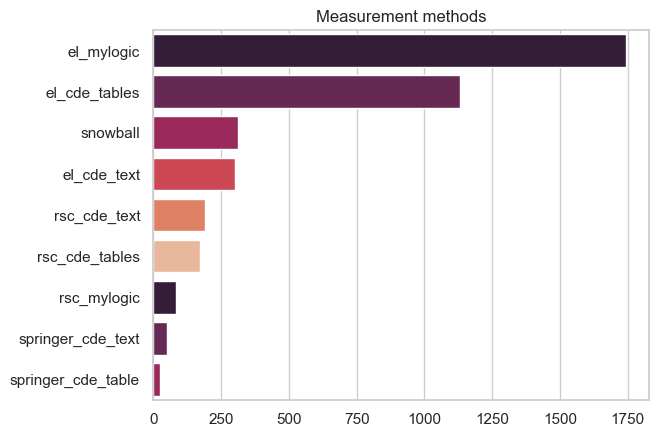

In [56]:
# plot shows which measument methods were used to get refractive indexes for this dataset
df2 = df.groupby(['measurement_method'])['measurement_method'].count().sort_values(ascending=False)
labels = list(df2.keys())
data = list(df2)
sns.barplot(x=data, y=labels, palette=sns.color_palette("rocket")).set_title('Measurement methods')

In [57]:
# plot shows distribution of refractive indexes within a certain measurement method
fig = px.histogram(df, 'raw_value', color='measurement_method')
fig.show()

### Statistical tests

Statistical test for categorical feature:
- H0 - there is no relationship between measurement methos and refractive index
- H1 - there is some relationship between measurement methos and refractive index

Since there are more than one groups of measurement methods in our dataset, one-way ANOVA test should be used.

In [59]:
from scipy.stats import f_oneway
data0= df_numeric[(df_numeric.measurement_method == 0)]['raw_value']
data1 = df_numeric[(df_numeric.measurement_method == 1)]['raw_value']
data2 = df_numeric[(df_numeric.measurement_method == 2)]['raw_value']
data3 = df_numeric[(df_numeric.measurement_method == 3)]['raw_value']
data4 = df_numeric[(df_numeric.measurement_method == 4)]['raw_value']
data5 = df_numeric[(df_numeric.measurement_method == 5)]['raw_value']
data6 = df_numeric[(df_numeric.measurement_method == 6)]['raw_value']
data7 = df_numeric[(df_numeric.measurement_method == 7)]['raw_value']
data8 = df_numeric[(df_numeric.measurement_method == 8)]['raw_value']
stat, p = f_oneway(data0, data1, data2, data3, data4, data5, data6, data7, data8)
print('stat={0:.3g}, p={0:.3g}'.format(stat, p))
if p > 0.05:
    print('Probably the same mean => There is NO relationship between refractive index and measurement method')
else:
    print('Probably different means => There is SOME relationship between refractive index and measurement method')

stat=0.467, p=0.467
Probably the same mean => There is NO relationship between refractive index and measurement method


### Linear dimnesionality reduction

Among available linear techniques PCA and ICA can be used for dimensinality reduction of our dataset. LDA is not appropriate here since it is a supervised method and our data is not labeled yet.

In [60]:
from sklearn.decomposition import FastICA
import matplotlib.cm as cm

Selection of the number of components

In [66]:
# perform ICA
ica = FastICA(n_components=20)
reduced_data = ica.fit_transform(df_normalized)

# calculate explained variance for components
ica_explained_variance = np.var(reduced_data, axis=0)

# calculate cumulative variance
explained_variance_ratio = ica_explained_variance / np.sum(ica_explained_variance)
y = np.cumsum(explained_variance_ratio)

# calculate principal components
xi = np.arange(1, y.shape[0]+1, step=1)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning:

Starting in v1.3, whiten='unit-variance' will be used by default.



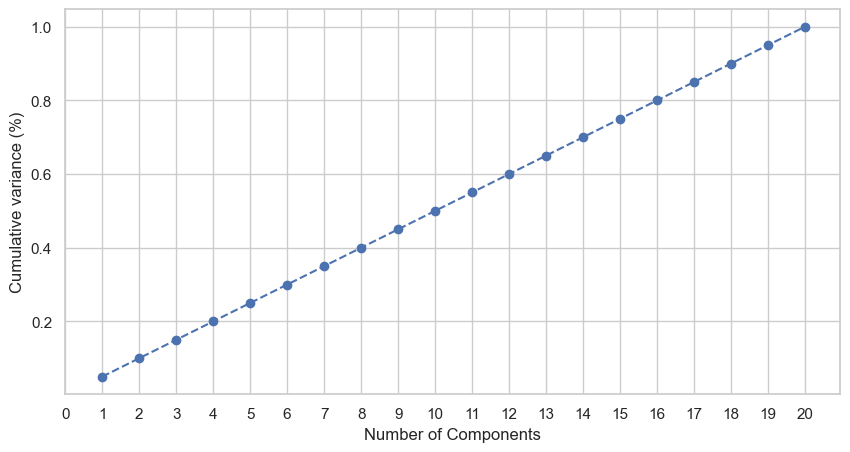

In [71]:
# plot results
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 21, step=1))
plt.ylabel('Cumulative variance (%)')
plt.show()

This plot illustrates the main difference between PCA and ICA. In ICA components are chosen by their statistical independence, not by their variance. That's why number of components for ICA is usually determined according to some prior knowledge about the features and the task itself. We will try ICA with 20 components.

In [72]:
# perform ICA with 20 components
ica = FastICA(n_components=20)
data_ica = ica.fit_transform(df_normalized)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning:

Starting in v1.3, whiten='unit-variance' will be used by default.



Explanation of components

In [81]:
# combine part of the original dataset with ICs
df_ica = pd.DataFrame(data = data_ica, columns = [f'IC{i}' for i in range(1,21)])
df_col = pd.concat([df_ica[['IC1', 'IC2', 'IC3']], pd.DataFrame(df_normalized.iloc[:, :10], columns=df_normalized.iloc[:, :10].columns)], axis=1)

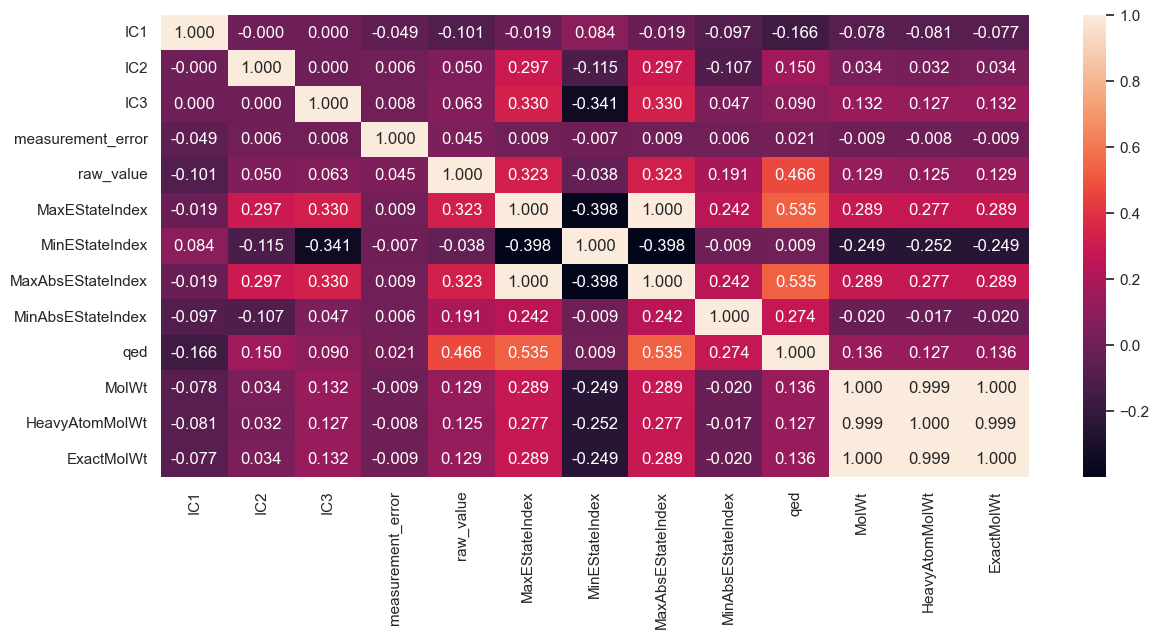

<Figure size 2800x1800 with 0 Axes>

In [82]:
# compute the correlations between the original data and ICs
corMatrix = pd.DataFrame.corr(df_col)

# plot the results
sns.set(rc={'figure.figsize':(14,6)})
sns.heatmap(corMatrix, annot=True, fmt='.3f')
plt.figure(figsize=(28,18))
plt.show()

Firstly, it is important to know that ICs do not correlate with each other.

Components can be explained by investigating correlations with initial features:
- IC1 decreases with the increase in "qed" feature. It means that IC1 can be thought as a measure of drug-likeness of molecular structures
- IC2 has positive correlation with "MaxEStateIndex" and "MaxAbsStateIndex"
- IC3 looks very similar to IC2, but also has a negative correlation with "MinEStateIndex"

### Non-linear dimensionality reduction

In [83]:
from sklearn.manifold import TSNE

In [85]:
# perform TSNE
tsne = TSNE(n_components=2, perplexity=120)
X_tsne = tsne.fit_transform(df_normalized)

# plot results
fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)
scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=Y, s=45, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
colorbar = fig.colorbar(scatter, ax=ax, label = "E")
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
sns.despine()
plt.show()